# __Predict labels with a PCM model and plot results__

The aim of this notebook is to load a PCM model, classify (predict) classes labels in a dataset and plot the results.

A PCM (__Profile Classification Model__) allows to automatically assemble ocean profiles in clusters according to their vertical structure similarities. Depending on the dataset, such clusters can show space/time coherence. That is what we call the __ocean patterns indicators__, and they will be revealed in the diferent plots. For more information about the method, see *Maze et al, Prg.Oc, 2017*.

You can develop, train and optimize a model using *Develop_PCM_model.ipynb* notebook or you can use an already trained model from *models/* folder.

Computation is done using the __pyxpcm python software__ (see documentation at https://pyxpcm.readthedocs.io)

This notebook have been develop in LOPS (Laboratoire d'océanoographie Physique et Spatiale), Ifremer, in the frame of BlueCloud european project.


<div>
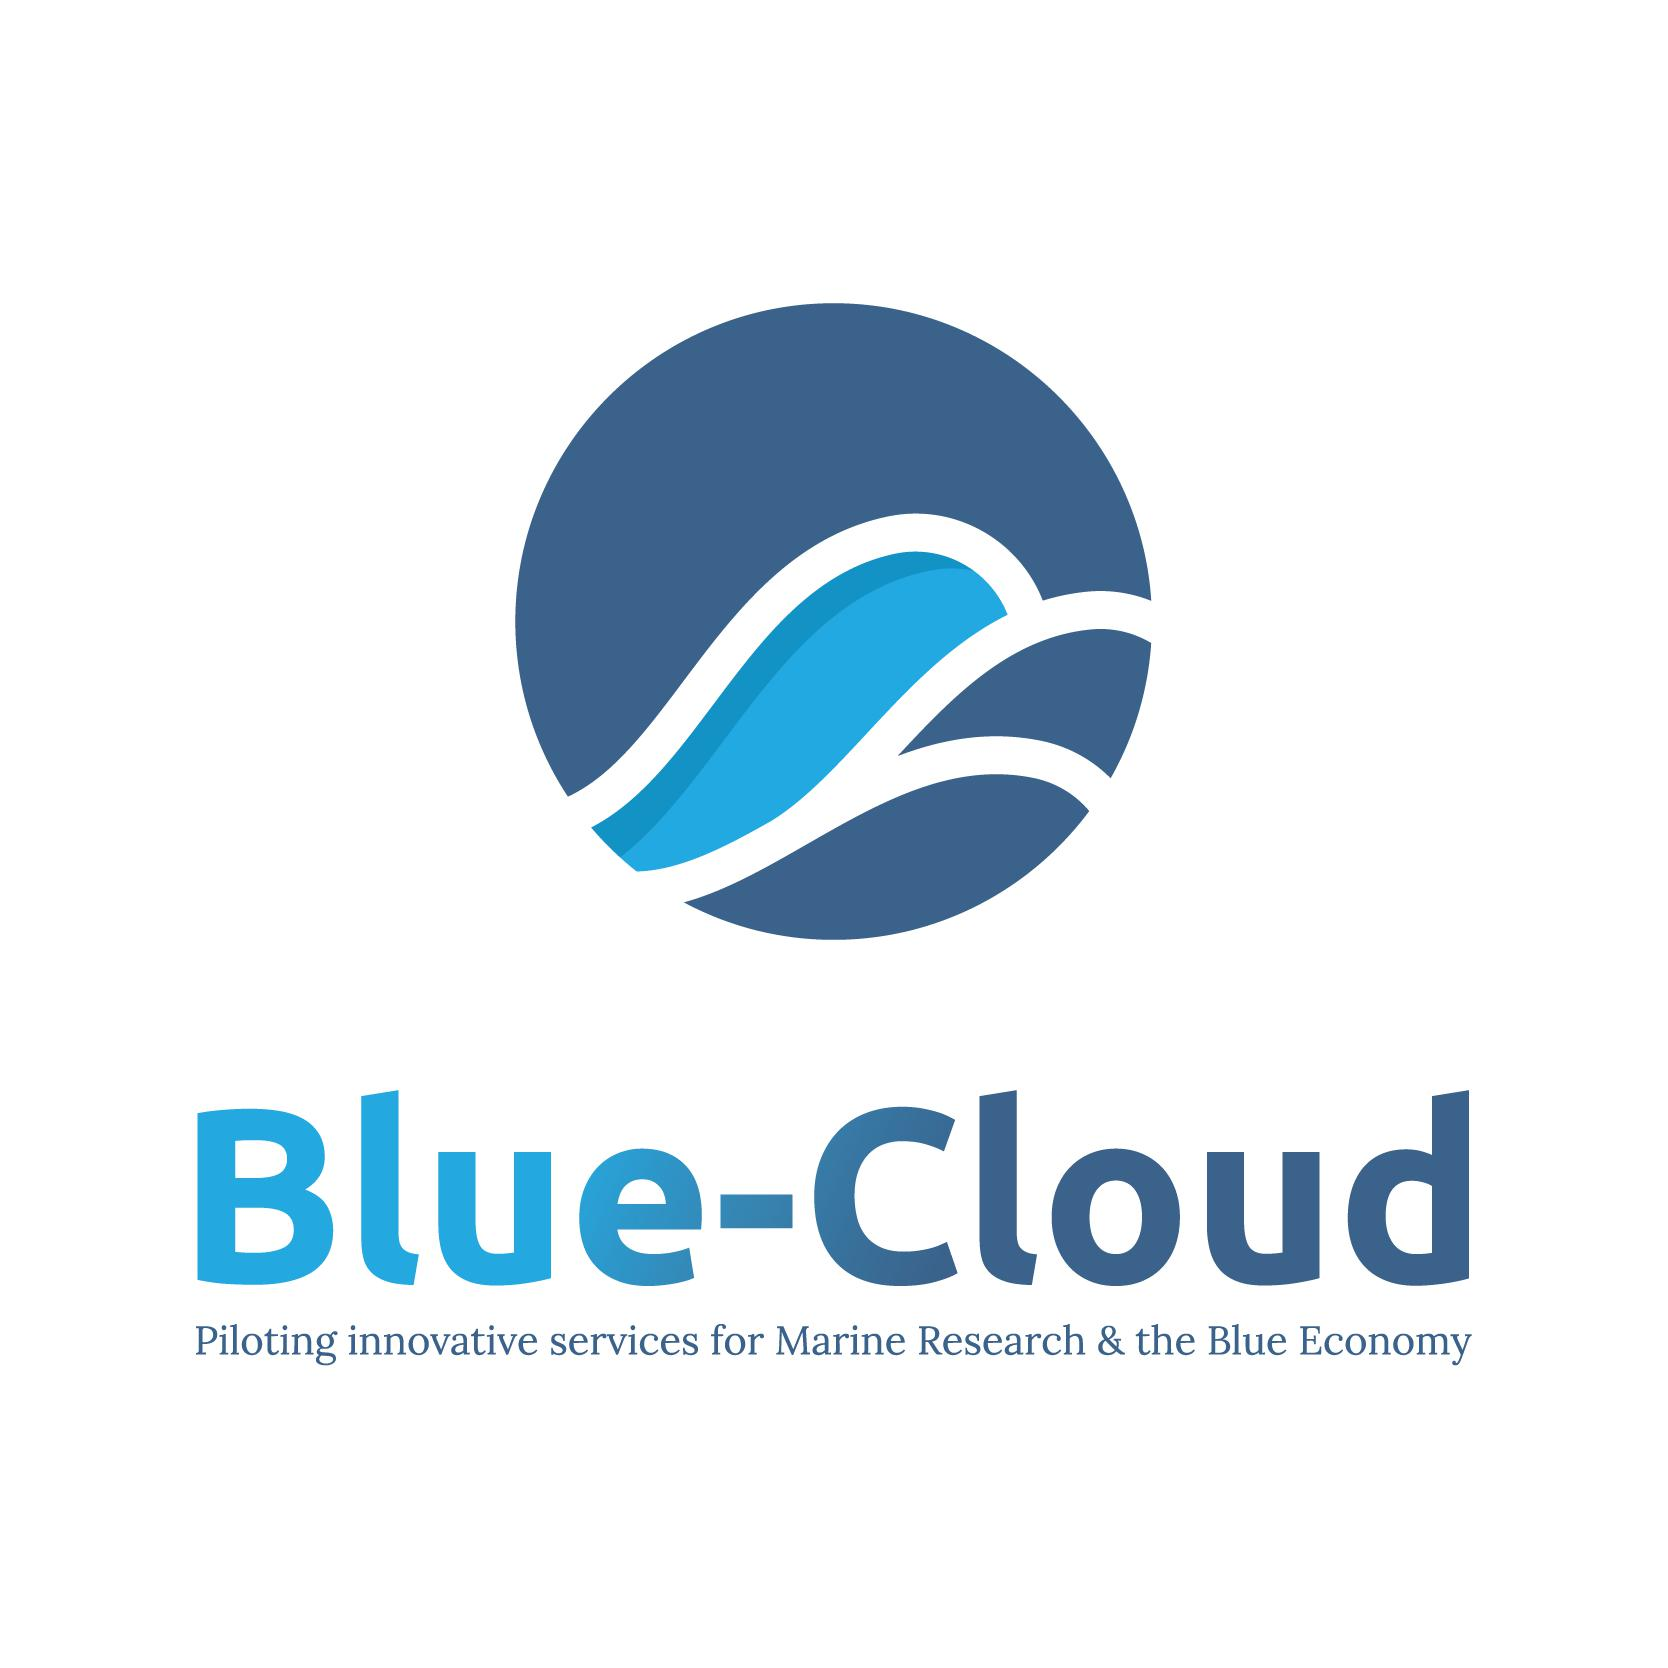 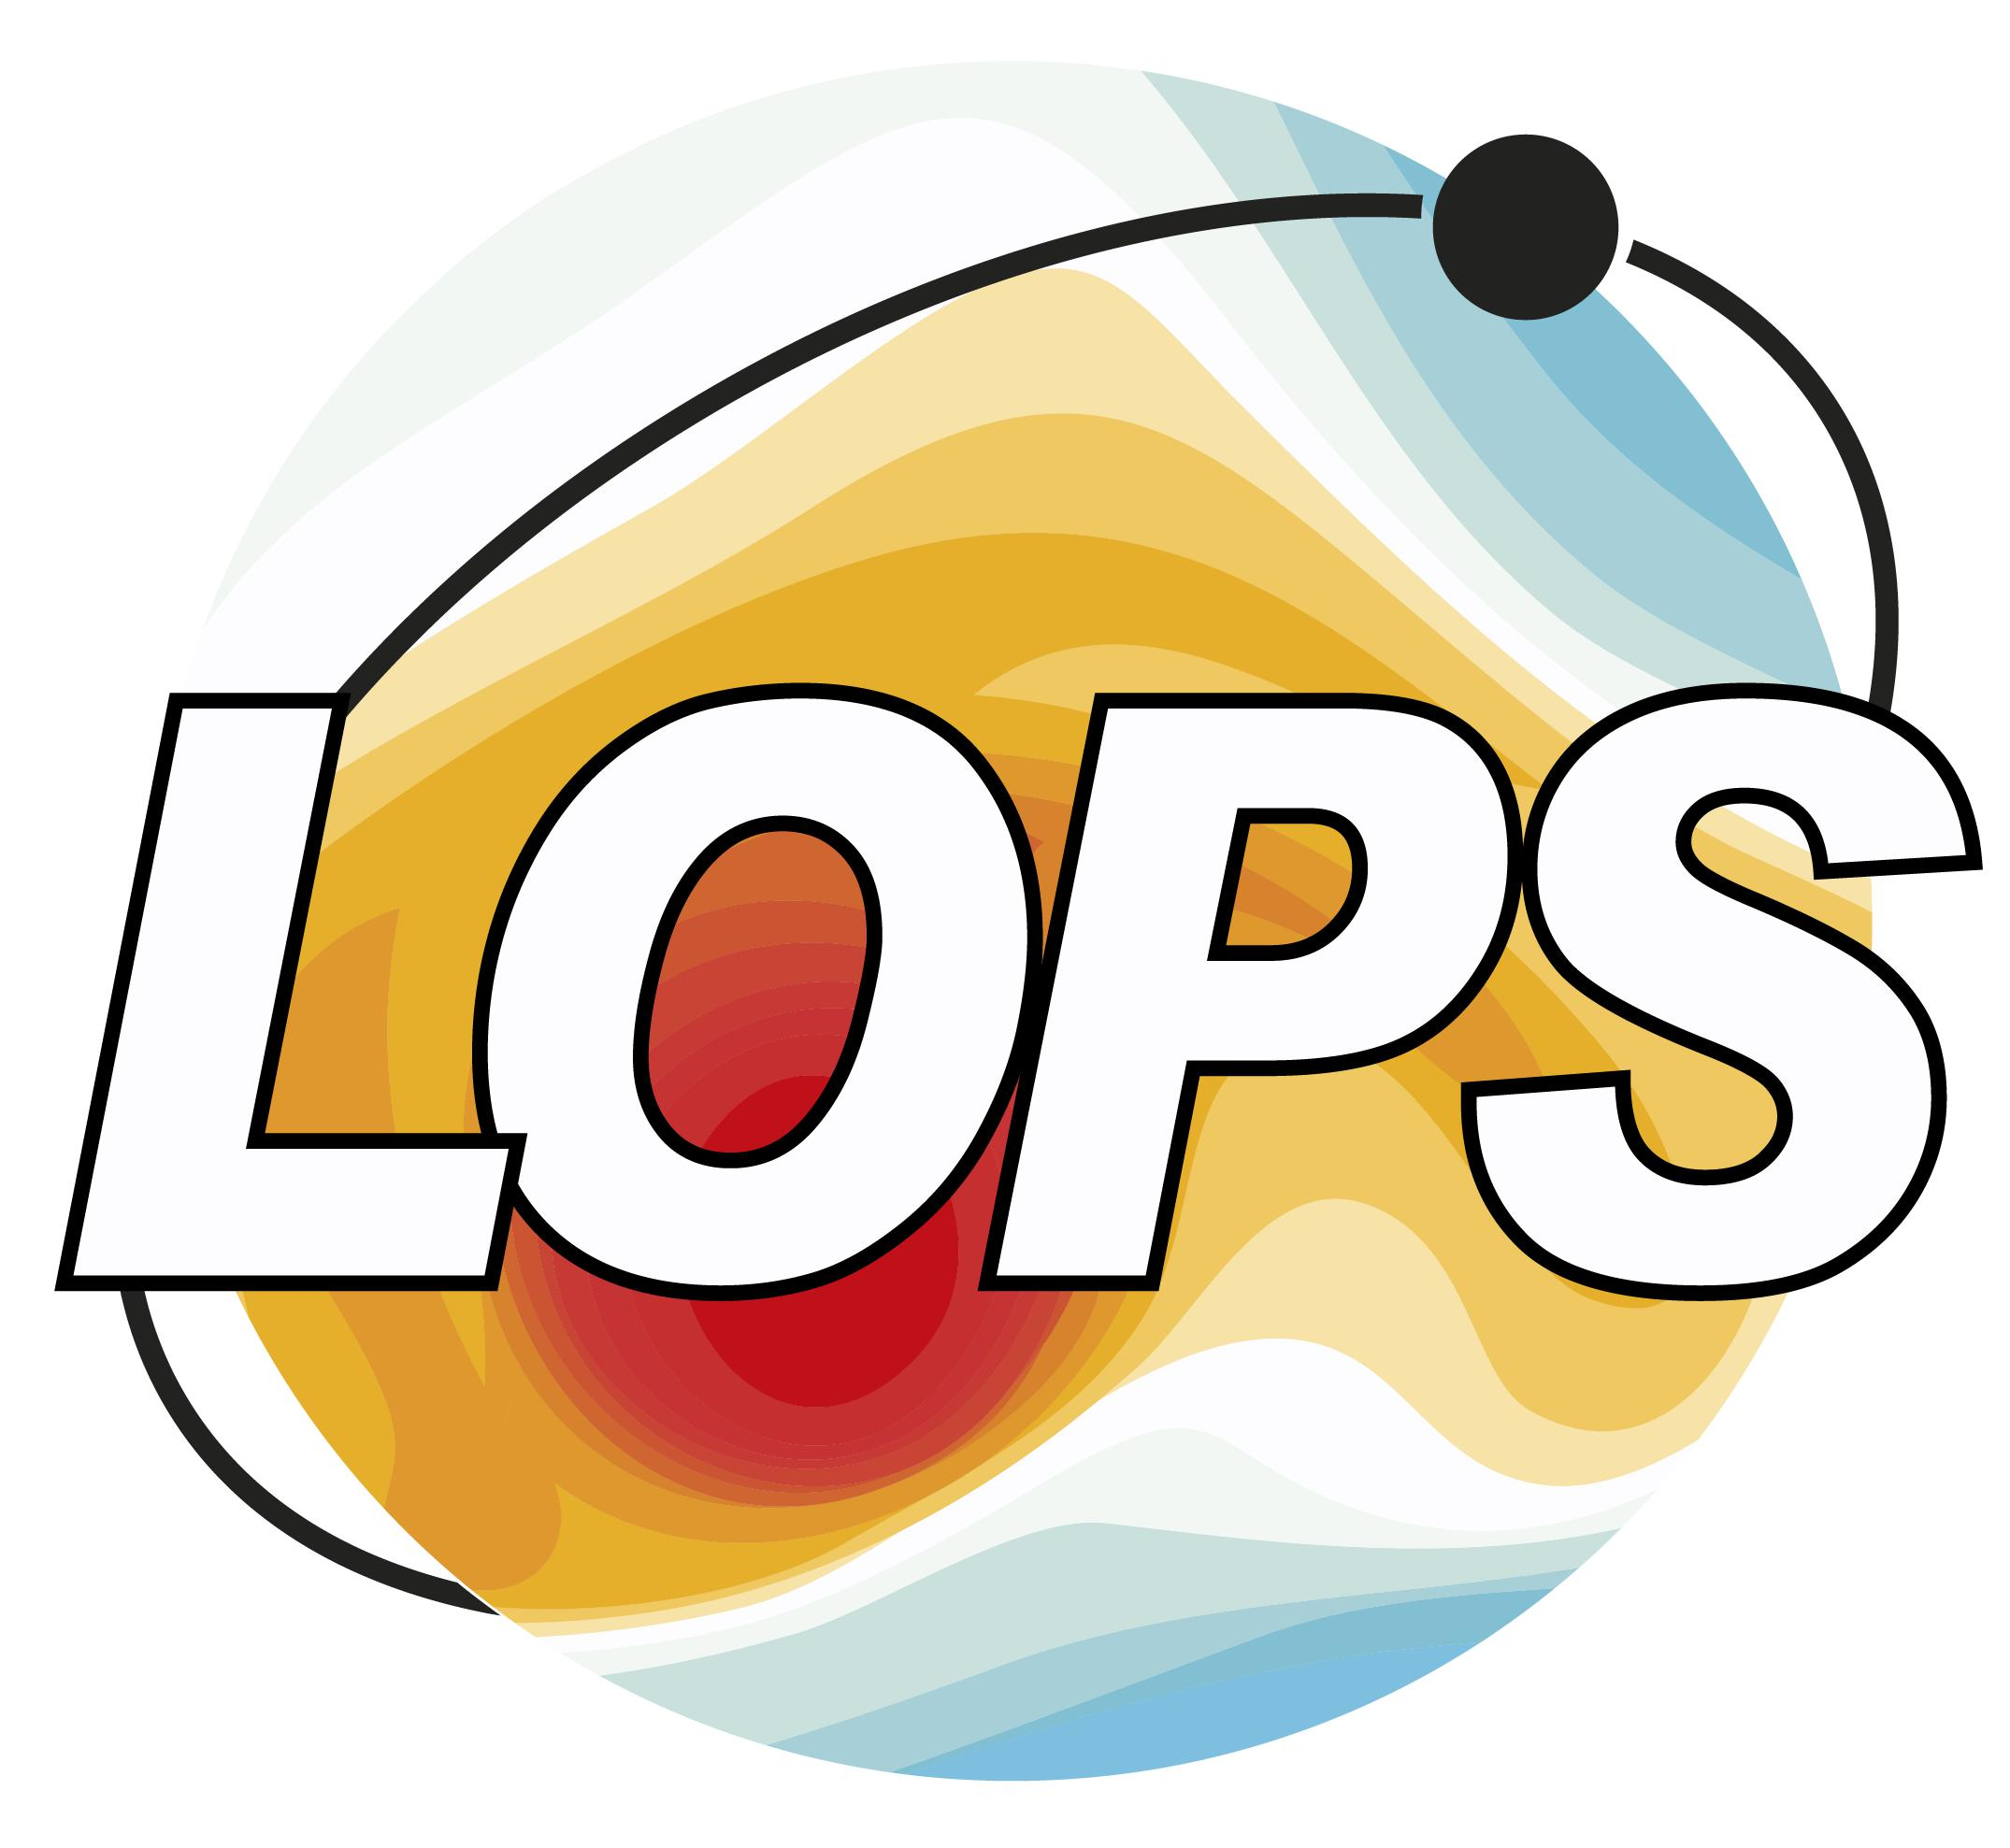
</div>


In [1]:
import xarray as xr
import numpy as np

import pyxpcm
from pyxpcm.models import pcm

import Plotter
from Plotter import Plotter #new class for plots in pyxpcm

## User input
***

In this section you should provide the __dataset__ and the __model__ paths, ans the name of the variables you want to use. You can develop, train and optimize a model using *Develop_PCM_model.ipynb* notebook or you can use an already trained model from *models/* folder.

You don't need to use the same dataset you used to train the model for making the prediction of labels. You can, for exemple, train de model with in situ data and apply it to a numerical model dataset in order to evaluate the numerical model realism.

The notebook have been optimazed to use some CMEMS products (see cell below). You can try to use other datasets but you should maybe modify some cells. 

__Choose dataset__

Dataset is download from CMEMS so we will need to have a CMEMS acount

In [8]:
CMEMS_user = 'agarcia6'
CMEMS_password = '1802910672Aa#'
# data_folder = 'datasets' #not working

SyntaxError: invalid syntax (<ipython-input-8-5a860a46872d>, line 2)

In [2]:
#### file path ####

# GLOBAL-ANALYSIS-FORECAST-PHY-001-024
#file_path = '/export/home1/agarciaj/datasets/global-analysis-forecast-phy-001-024_1598520725098.nc'

# GLOBAL_REANALYSIS_PHY_001_030
file_path = '/export/home1/agarciaj/datasets/global-reanalysis-phy-001-030-monthly_1601036810235.nc'

# GLOBAL_REANALYSIS_PHY_001_031
#file_path = '/export/home1/agarciaj/datasets/global-reanalysis-phy-001-031-grepv2-monthly_1598972586332.nc'

# GLOBAL_REANALYSIS_BIO_001_029
#file_path = '/export/home1/agarciaj/datasets/global-reanalysis-bio-001-029-monthly_1598524945308.nc

Variables names in dataset (__TODO__: find an elegant way to do that)

In [3]:
# z dimension and varible names (expecify then here but use a generic name in the rest of the notebook)
z_dim = 'depth' 
var_name = 'thetao' # var_name = 'fe' 

__Choose model__

In [4]:
# Model path
model_path = 'models/tests_model_GLOBAL_REANALYSIS_PHY_001_030_temp.nc'

# Variable to be predict {variable name in model: variable name in dataset}
features_in_ds = {'temperature': var_name}

## Load model and dataset
***

*pyxpcm* and *xarray* libraries are used to load the chosen model and the chosen dataset

__Load model__

In [5]:
m = pyxpcm.load_netcdf(model_path)
m

<pcm 'gmm' (K: 8, F: 1)>
Number of class: 8
Number of feature: 1
Feature names: odict_keys(['temperature'])
Fitted: True
Feature: 'temperature'
	 Interpoler: <class 'pyxpcm.utils.Vertical_Interpolator'>
	 Scaler: 'normal', <class 'sklearn.preprocessing._data.StandardScaler'>
	 Reducer: True, <class 'sklearn.decomposition._pca.PCA'>
Classifier: 'gmm', <class 'sklearn.mixture._gaussian_mixture.GaussianMixture'>
	 log likelihood of the training set: 43.932334

__Load dataset__

In [9]:
# download file from CMEMS
!pip install motuclient --upgrade
!python -m motuclient -u agarcia6 -p 1802910672Aa# -m "http://my.cmems-du.eu/motu-web/Motu" \
-s GLOBAL_REANALYSIS_PHY_001_030-TDS -d global-reanalysis-phy-001-030-daily \
-x -5 -X 35 -y 30 -Y 46 -t "2017-01-01" -T "2017-01-31" -z 0.0 -Z 2500.0 \
-v so -v thetao -o datasets -f global-reanalysis-phy-001-030-daily_med_1.nc

Requirement already up-to-date: motuclient in /export/home1/agarciaj/anaconda3/lib/python3.7/site-packages (1.8.5)
2020-10-21 09:48:30.411 [ INFO] Asynchronous mode set
2020-10-21 09:48:30.411 [ INFO] Authenticating user agarcia6 for service http://my.cmems-du.eu/motu-web/Motu
2020-10-21 09:48:30.942 [ INFO] Requesting file to download (this can take a while)...
2020-10-21 09:48:31.353 [ INFO] Authenticating user agarcia6 for service http://my.cmems-du.eu/motu-web/Motu
2020-10-21 09:48:32.237 [ INFO] Product is not yet available (request in progress)
2020-10-21 09:48:42.247 [ INFO] Authenticating user agarcia6 for service http://my.cmems-du.eu/motu-web/Motu
2020-10-21 09:48:43.169 [ INFO] Product is not yet available (request in progress)
2020-10-21 09:48:53.180 [ INFO] Authenticating user agarcia6 for service http://my.cmems-du.eu/motu-web/Motu
2020-10-21 09:48:54.109 [ INFO] Product is not yet available (request in progress)
2020-10-21 09:49:04.120 [ INFO] Authenticating user agarcia

In [6]:
ds = xr.open_dataset(file_path)

# format
# depth should be negative
ds['depth'] = -np.abs(ds['depth'].values)
# depth attribute 'axis' for Plotter instance
ds.depth.attrs['axis'] = 'Z'
ds

<xarray.Dataset>
Dimensions:    (depth: 50, latitude: 205, longitude: 577, time: 12)
Coordinates:
  * depth      (depth) float32 -0.494025 -1.541375 ... -5274.784 -5727.917
  * latitude   (latitude) float32 30.0 30.083334 30.166666 ... 46.916668 47.0
  * time       (time) datetime64[ns] 2018-01-16T12:00:00 ... 2018-12-16T12:00:00
  * longitude  (longitude) float32 -6.0 -5.9166665 -5.8333335 ... 41.916668 42.0
Data variables:
    mlotst     (time, latitude, longitude) float32 ...
    vo         (time, depth, latitude, longitude) float32 ...
    thetao     (time, depth, latitude, longitude) float32 ...
    uo         (time, depth, latitude, longitude) float32 ...
    bottomT    (time, latitude, longitude) float32 ...
    so         (time, depth, latitude, longitude) float32 ...
    zos        (time, latitude, longitude) float32 ...
Attributes:
    title:                         Monthly mean fields for product GLOBAL_REA...
    references:                    http://marine.copernicus.eu
    credit:                        E.U. Copernicus Marine Service Information...
    licence:                       http://marine.copernicus.eu/services-portf...
    contact:                       servicedesk.cmems@mercator-ocean.eu
    producer:                      CMEMS - Global Monitoring and Forecasting ...
    institution:                   Mercator Ocean
    Conventions:                   CF-1.6
    area:                          GLOBAL
    product:                       GLOBAL_REANALYSIS_001_030
    dataset:                       global-reanalysis-001-030-monthly
    source:                        MERCATOR GLORYS12V1
    product_user_manual:           http://marine.copernicus.eu/documents/PUM/...
    quality_information_document:  http://marine.copernicus.eu/documents/QUID...
    _CoordSysBuilder:              ucar.nc2.dataset.conv.CF1Convention
    comment:                       
    history:                       Data extracted from dataset http://localho...

Quick plot of dataset. Please, choose time and depth slide if needed.

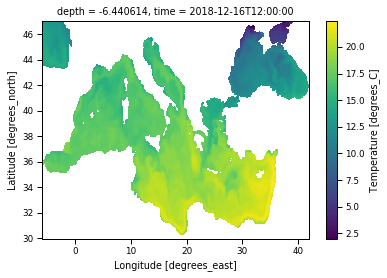

In [7]:
ds[var_name].isel(time=11, depth=5).plot();

## Predict labels
***

Classes labels and some statistics are computed using *pyxpcm* library. New variables with the results are added to the dataset (`inplace=True` option)

__Predict class labels__

In [8]:
m.predict(ds, features=features_in_ds, dim=z_dim, inplace=True);

__Probability of a profile to be in a class__ (Posteriors)

In [9]:
m.predict_proba(ds, features=features_in_ds, dim=z_dim, inplace=True);

__Classes quantiles__ (q=0.5 median profiles representing each class)

In [10]:
ds = ds.pyxpcm.quantile(m, q=[0.05, 0.5, 0.95], of=var_name, outname=var_name + '_Q', keep_attrs=True, inplace=True)

/export/home1/agarciaj/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1390: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)


__Robustness__

In [11]:
ds.pyxpcm.robustness(m, inplace=True)
ds.pyxpcm.robustness_digit(m, inplace=True)

<xarray.Dataset>
Dimensions:             (depth: 50, latitude: 205, longitude: 577, pcm_class: 8, quantile: 3, time: 12)
Coordinates:
  * pcm_class           (pcm_class) int64 0 1 2 3 4 5 6 7
  * depth               (depth) float32 -0.494025 -1.541375 ... -5727.917
  * latitude            (latitude) float64 30.0 30.08 30.17 ... 46.83 46.92 47.0
  * time                (time) datetime64[ns] 2018-01-16T12:00:00 ... 2018-12-16T12:00:00
  * longitude           (longitude) float64 -6.0 -5.917 -5.833 ... 41.92 42.0
  * quantile            (quantile) float64 0.05 0.5 0.95
Data variables:
    mlotst              (time, latitude, longitude) float32 nan nan ... nan nan
    vo                  (time, depth, latitude, longitude) float32 nan ... nan
    thetao              (time, depth, latitude, longitude) float32 nan ... nan
    uo                  (time, depth, latitude, longitude) float32 nan ... nan
    bottomT             (time, latitude, longitude) float32 nan nan ... nan nan
    so                  (time, depth, latitude, longitude) float32 nan ... nan
    zos                 (time, latitude, longitude) float32 nan nan ... nan nan
    PCM_LABELS          (time, latitude, longitude) float64 nan nan ... nan nan
    PCM_POST            (pcm_class, time, latitude, longitude) float64 nan ... nan
    thetao_Q            (pcm_class, quantile, depth) float64 9.169 9.167 ... nan
    PCM_ROBUSTNESS      (time, latitude, longitude) float64 nan nan ... nan nan
    PCM_ROBUSTNESS_CAT  (time, latitude, longitude) int64 5 5 5 5 5 ... 5 5 5 5
Attributes:
    title:                         Monthly mean fields for product GLOBAL_REA...
    references:                    http://marine.copernicus.eu
    credit:                        E.U. Copernicus Marine Service Information...
    licence:                       http://marine.copernicus.eu/services-portf...
    contact:                       servicedesk.cmems@mercator-ocean.eu
    producer:                      CMEMS - Global Monitoring and Forecasting ...
    institution:                   Mercator Ocean
    Conventions:                   CF-1.6
    area:                          GLOBAL
    product:                       GLOBAL_REANALYSIS_001_030
    dataset:                       global-reanalysis-001-030-monthly
    source:                        MERCATOR GLORYS12V1
    product_user_manual:           http://marine.copernicus.eu/documents/PUM/...
    quality_information_document:  http://marine.copernicus.eu/documents/QUID...
    _CoordSysBuilder:              ucar.nc2.dataset.conv.CF1Convention
    comment:                       
    history:                       Data extracted from dataset http://localho...

## Plot results
***

Plots are created using the *Plotter* class, which is instantiate below. Plots include the vertical structure of classes, the spatial distribution and the temporal distribution of classes. These plots would allow you to determine if classes show a spacial or temporal coherence: the __ocean patterns indicators__.

*save_BlueCloud* function save the figure and add dataset information and logos below. 

Please, feel free to change plot options if you need it.

In [12]:
P = Plotter(ds, m)

#### __1. Vertical structure of classes__

In [ ]:
P.vertical_structure(q_variable = var_name + '_Q', sharey=True, xlabel='Temperature (°C)')
#P.save_BlueCloud('figures/vertical_struc_EX.png')
P.save_BlueCloud('figures/test.png')

In [ ]:
P.vertical_structure_comp(q_variable = var_name + '_Q', plot_q= 'all', xlabel='Temperature (°C)')
#P.save_BlueCloud('figures/vertical_struc_comp_EX.png')
P.save_BlueCloud('figures/test.png')

#### __2. Spatial distribution of classes__

Figure saved in figures/test.png


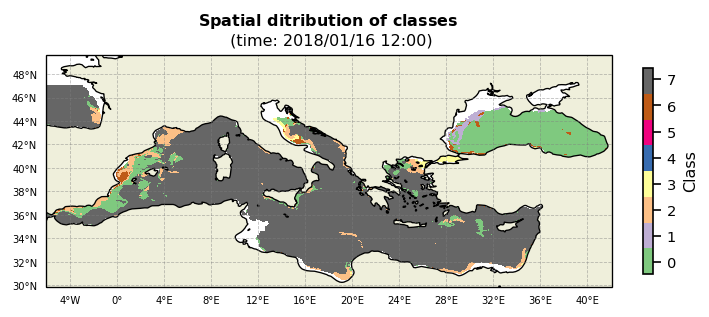

In [13]:
# Input should have only one time step
P.spatial_distribution(time_slice="2018-01-01")
#P.save_BlueCloud('figures/spatial_distr_EX.png')
P.save_BlueCloud('figures/test.png')

In [ ]:
P.spatial_distribution(time_slice='most_freq_label')
#P.save_BlueCloud('figures/spatial_distr_freq_EX.png')
P.save_BlueCloud('figures/test.png')

#### __3. Robustness__

In [ ]:
# Input should have only one time step
P.plot_robustness(time_slice="2018-01-01")
#P.save_BlueCloud('figures/robustness_EX.png')
P.save_BlueCloud('figures/test_robustness.png')

#### __4. Classes pie chart__

Figure saved in figures/test.png


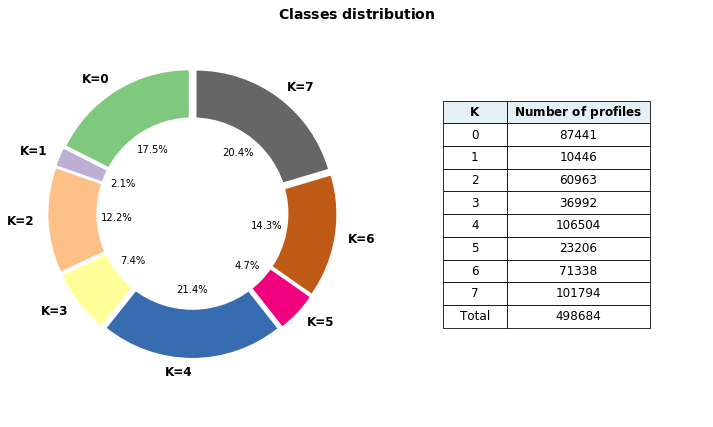

In [15]:
P.pie_classes()
#P.save_BlueCloud('figures/pie_chart_EX.png')
P.save_BlueCloud('figures/test.png')

#### __4. Temporal representation__ 

Bar plot by __month__

In [ ]:
P.temporal_distribution(time_bins = 'month')
#P.save_BlueCloud('figures/temporal_distr_months_EX.png')
P.save_BlueCloud('figures/test.png')

Bar plot by __season__

In [ ]:
P.temporal_distribution(time_bins = 'season')
#P.save_BlueCloud('figures/temporal_distr_season_EX.png')
P.save_BlueCloud('figures/test.png')